# Assignment - Week 2

## Problem Statement

Implement the Variational Quantum Eigensolver (VQE) algorithm to determine the ground state and ground state energy of a simple Hamiltonian system using Qiskit.

1. Hamiltonian Definition:
   - Use the following Hamiltonian for a 2-qubit system:
    $H = X_0 X_1 + Y_0 Y_1 + Z_0 I_1$, here, $X, Y$ and $Z$ are Pauli operators, and $I$ is the identity operator.
2. Variational Ansatz:
   - Design a parameterized quantum circuit (ansatz) using rotational gates ($R_y, R_z$) and entangling gates (e.g., CNOT)
   - The ansatz should be general enough to approximate the ground state.
3. Cost Function:
   - Define the cost function as the expectation value of the Hamiltonian with respect to the trial state produced by the ansatz.
4. Optimization:
   - Use a classical optimizer (like gradient descent) to minimize the cost function and determine the parameters that approximate the ground state.
5. Execution:
   - Simulate the VQE circuit using Qiskit’s Aer simulator.
   - Compare the obtained ground state energy with the exact solution obtained via Qiskit’s NumPyMinimumEigensolver.
6. Results and Analysis:
   - Print the optimized ground state energy.
   - Compare it to the exact eigenvalue of the Hamiltonian.
   - Plot the convergence of the cost function over optimization iterations.

### Guidelines
- Refer to the Qiskit documentation for implementing VQE circuits and classical optimizers.
- Ensure that the code is modular, with clear comments explaining each step.


## Solution

Here, I implement a VQE solver, using **hardware-efficient ansatz** with two rotational and one entangling gate per layer, **hamiltonian** expressed as a linear combination of Pauli strings and **gradient descent** based classical optimizer.

The essential subroutines are all implemented with code, utilizing as few library methods as possible.

### Ideas for further improvement
1. Explore other gradient based optimizers like Adam
2. Utilize parallelized computation for gradient calculation
3. Explore other ansatz structures

## References
1. [IBM Quantum | Tutorials | Variational Quantum Eigensolver](https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver)
2. [IBM Quantum | Guides | `AerSimulator`](https://docs.quantum.ibm.com/migration-guides/local-simulators#aersimulator)
3. [`scipy.linalg.eigh`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eigh.html)
4. Cerezo, M., Arrasmith, A., Babbush, R., Benjamin, S. C., Endo, S., Fujii, K., ... & Coles, P. J. (2020). Variational quantum algorithms. *arXiv preprint arXiv:2012.09265*. Available at: [https://arxiv.org/pdf/2012.09265](https://arxiv.org/pdf/2012.09265), p. 8.


In [16]:
import numpy as np

from scipy.linalg import eigh

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp, Statevector

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2
from qiskit_aer import AerSimulator

import matplotlib.pyplot as plt

from itertools import product

In [17]:
%matplotlib widget

## General Functions
The functions below cover the main steps of making a variational quantum eigensolver (VQE).

#### 1. Ansatz $U$
`parameterized_ansatz(...)` returns a parametrizable ansatz (`QuantumCircuit`) and the number of parameters.

Here, we are using **hardware-efficient ansatz** with 2 rotationnal ($R_y, R_z$) gates followed by entangling ($\text{CNOT}$) gates, repeated for a few layers.

`linear=True` entangles `i`-th qubit with `i+1`-th using CNOT (except last), hence linear. `linear=False` entangles last qubit to first using CNOT, hence circular entanglement.

The initial state is taken to be $\ket{0}^{\otimes N}$

#### 2. Observables (Hamiltonian) ($\hat{H}$)

The Hamiltonian is defined as a linear combination of Pauli strings $\hat{H} = \sum_{a} w_a \hat{P_a}$, where $\hat{P_a} \in \{I, X, Y, Z\}^{\otimes N}$

`expectation(...)` is used to return expectation value of given observable $\langle O \rangle \equiv \text{Tr}[O \ket{\psi(\theta)}\bra{\psi(\theta)}]$, where $\ket{\psi(\theta)} = U(\theta) \ket{\psi_0}$

This is where we get a speed up on quantum systems, as with sparse Hamiltonians, the computational cost only grows polynomially. (ref 4)

#### 3. Parameters $\theta$

`initialize_parameters(...)` is used to initialize random parameters in `[0, 2pi)`.

#### 4. Cost Function $C(\{O_k\}, \{U\}, \theta)$

It is implemented in `cost_fn(...)` as $C(\theta) = \langle H \rangle$, which is run on quantum device using the Aer simulator.

#### 5. Optimizer

The classical optimizer uses **stochastic gradient descent (SGD)** using two functions:
- `calculate_gradients(...)` is used to calculate gradients using the **parameter-shift rule** (the norm of gradient is also logged in a seperate variable for plotting later)
  $$
  \nabla C(\theta) = \sum_{i} \frac{\partial C}{\partial \theta_i} \hat{e_i} = \frac{1}{2 \sin(\alpha)} \sum_{i} C(\theta + \alpha \hat{e_i}) - C(\theta - \alpha \hat{e_i})
  $$
- `update_parameters(...)` runs the main optimizer routine, returning new $\theta$ as $\theta_{\text{new}} = \theta - \eta \nabla C(\theta)$

One of the key advantages of VQE is that the optimizer reuses the same circuit and observable as the cost function, and each gradient calculation can be done in parallel

---

Almost all functions are modular and can be adapted to different VQAs, except last 3, which have fixed implementations of given cost function and optimizers, which can be changed to accomodate more complex problems.

![VQE Illustration](./vqe-illustration.png)

*Image source: [wikipedia](https://en.wikipedia.org/wiki/File:VQE_Illustration.png)*

In [18]:
def parameterized_ansatz(n_qubits = 2, n_layers = 1, linear = True):
    '''
    Return (parametrizable ansatz, number of parameters)
    '''

    qc = QuantumCircuit(n_qubits)
    th = []
    
    # number of params per qubit per layer
    # fixed coz Ry, Rz used
    n_params = 2
    
    # create param placeholders
    for i in range(n_layers):
        for j in range(n_qubits):
            th.append(Parameter(f"th_{i}_{j}_Ry"))
            th.append(Parameter(f"th_{i}_{j}_Rz"))

    # apply gates
    k = 0
    for _ in range(n_layers):
        for j in range(n_qubits):
            # convention: first angle is for Ry
            qc.ry(th[k], j)
            k += 1
            qc.rz(th[k], j)
            k += 1

        for j in range(n_qubits):
            # using linear entanglement ONLY for case of 2-qubits
            # because with change of basis, we can see that CX affects
            # both qubits equally, so expressibility won't be affected (probably)
            
            # if not linear, do circular entanglement
            if (j == n_qubits - 1) and not linear:
                qc.cx(j, 0)
            elif j < n_qubits - 1:
                qc.cx(j, j + 1)
    
    return qc, k


def initialize_parameters(n_params, vals = None, seed = None) -> np.ndarray:
    '''
    Return `np.ndarray` of size `(n_params,)`
    `vals`:
    - `None` (default): randomly initialized
    - Numeric: all set to `vals` E [0, 2pi)
    
    `seed`: (only used if random initialization is used)
    - `None` (default): random seed
    - `int`: given seed is used 
    '''
    if vals is None:
        rng = np.random.default_rng(seed)
        return rng.uniform(0, 2 * np.pi, size=(n_params,))
    else:
        # assuming vals E [0, 2pi)
        return np.ones(size=(n_params,)) * vals


def expectation(ansatz, observable, estimator, th):
    '''
    Return expectation of `observable` on `ansatz` with params `th` run using `estimator`
    '''
    return estimator.run(pubs=[(ansatz, [observable], [th])]).result()[0].data.evs[0]


def cost_fn(ansatz, observables, estimator, th, history=None):
    '''
    Return cost for `ansatz` with params `th` with `observables`, run using `estimator`
    `history` is an external var to keep track of returned values.
    '''
    # using C(th) = <O>, where O = Hamiltonian
    # only one observable
    cost = expectation(ansatz, observables[0], estimator, th)

    # modify cost history
    if history is not None:
        history["prev_th"] = th
        history["cost"].append(cost)
    
    return cost


def calculate_gradients(bound_cost_fn, th, alpha, history=None):
    '''
    Return gradient using the parameter shift rule:
    
    `grad C = (C(th+) - C(th-)) / (2 * sin(alpha))`
    
    as `np.ndarray` of size `(n,1)`
    '''
    
    # apply using: th +- alpha*I
    # where th (n,1) is broadcast to size (n,n) of I
    n = th.size
    delta = np.identity(n) * alpha
    
    grad = np.zeros(n)

    grad += (bound_cost_fn(th + delta) - bound_cost_fn(th - delta))
    
    grad /= (n * 2 * np.sin(alpha))
    
    if history is not None:
        history["grad_norm"].append(np.linalg.norm(grad))
    
    return grad


def update_parameters(th, gradients, learning_rate, mode = 'sgd'):
    '''
    Return `th` updated
    
    `mode` = (`sgd`)
    
    `th' = th - grad * learning_rate`
    '''
    th_prime = th - gradients * learning_rate
    return th_prime
    

## Helper Functions
For computing theoretical values, measuring efficacy of algorithm and, ploting and analyzing results.

**Note:** `qiskit.algorithms.NumPyEigensolver` was deprecated in Qiskit 0.4 and is now removed based on online API docs, so `scipy.linalg.eigh` is used for getting eigenvals of hermitian matrix (ref 3).

In [19]:
def compute_theoretical_values(observable):
    """
    Return ground state, and ground state energy corresponding to given hermitian observable
    """
    # `qiskit.algorithms.NumPyEigensolver` was deprecated in Qiskit 0.4 and is now removed based on online API docs
    # using `scipy.linalg.eigh` for getting eigenvals

    matrix = observable.to_matrix(sparse=False)
    eigenvals, eigenvecs = eigh(matrix)
    return (eigenvecs[:, 0], eigenvals[0])


def evaluate_efficacy(
    gs, gs_energy, gs_theoretical, gs_energy_theoretical, costs, w=5, eps=5
):
    """
    Return
        (rel pc error in gs energy (accuracy),
        rel pc std devn in gs energy after `k` (spread),
        fidelity/norm squared of inner product of gs with gs_theoretical,
        no. of iters `k` when `w` moving avg. cost gets in `eps` rel.pc. of final val)
    """
    # rel pc error in gs energy
    error_rel_pc = (
        abs((gs_energy - gs_energy_theoretical) / gs_energy_theoretical) * 100
    )

    # norm squared of inner product of gs with gs_theoretical
    fidelity = abs(np.conj(gs_theoretical).T @ gs) ** 2

    # no. of iterations before moving average comes within epsilon (rel pc) of final value
    moving_av_abs_diff = abs(
        (np.sum([costs[i : i + 1 - w] for i in range(w - 1)], axis=0) + costs[w - 1 :])
        / w
        - gs_energy
    )
    k = -1
    for i, diff in enumerate(moving_av_abs_diff):
        if diff <= eps * abs(gs_energy) / 100:
            k = i + w // 2
            break

    # rel pc std dev in gs energy, after `k`
    stddev_rel_pc = (
        np.average((costs[k:] - gs_energy) ** 2) / abs(gs_energy_theoretical) * 100
    )

    # https://en.wikipedia.org/wiki/iters_to_converge#Asymptotic_rates_of_convergence_for_iterative_methods
    # fit a curve: log(e_k+1) = q*log(e_k) + log(c)
    # q -> order of convergence
    # c_min = gs_energy
    # e_k = abs(costs - c_min)
    # log_e_kplus1 = np.log(e_k[1:])
    # log_e_k = np.log(e_k[:-1])
    # q, _, _, _, _ = linregress(log_e_k, log_e_kplus1)

    # fit the curve: E = E_0 + A * exp(-ck)
    # k_values = np.arange(len(costs))
    # A_init = costs[0] - gs_energy_theoretical
    # popt, _ = curve_fit(lambda k, A, c: (gs_energy_theoretical + A * np.exp(-c * k)), k_values, costs, p0=[A_init, 0.1])
    # _, c = popt

    return (error_rel_pc, stddev_rel_pc, fidelity, k)


def plot_results(n_iters, history, gs_energy_theoretical, plot=None, label=None):
    if plot is None:
        plot = plt.subplots(1, 2, figsize=(16, 6))
    f, (ax1, ax2) = plot

    # NOTE:
    # to prevent cluttering only every `step` data point is sampled
    # another option is to use a moving average to smoothen it out
    # but that may hide the fluctuations which are fundamental to this optimizing method
    step = 10

    # moreover, to emphasize the differences in cost function decay
    # a log scale is used, plotting abs. error between
    # true minimum and cost fn val
    # and log value of grad norm, respectively
    # errors = np.log10(np.abs(history["cost"][::step] - gs_energy_theoretical))
    # log_grad_norm = np.log10(history["grad_norm"][::step])
    errors = history["cost"][::step]
    log_grad_norm = history["grad_norm"][::step]

    # plot C(θ) vs Iterations
    if label is None:
        ax1.plot(np.arange(0, n_iters, step), errors)
    else:
        ax1.plot(np.arange(0, n_iters, step), errors, label=label)
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("C(θ)")

    # plot theoretical ground state energy
    ax1.axhline(y=gs_energy_theoretical, color="r", ls="--")
    ax1.set_yticks(list(ax1.get_yticks()) + [gs_energy_theoretical])

    # plot ||∇C(θ)|| vs Iterations
    if label is None:
        ax2.plot(np.arange(0, n_iters, step), log_grad_norm)
    else:
        ax2.plot(np.arange(0, n_iters, step), log_grad_norm, label=label)
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("|| ∇C(θ) ||")
    ax2.set_ylim(bottom=0)

    if label is not None:
        ax1.legend()
        ax2.legend()

    return (f, (ax1, ax2))


def analyze_results(results):
    print("Iterations:", results["iterations"])
    print("Total cost evaluations:", results["total_cost_fn_evals"])
    print("Circuit depth:", results["circuit_depth"])
    print("δE₀ (error) =", results["error"], "%")
    print("ΔE₀ (spread) =", results["spread"], "%")
    print("No. of iters to converge =", results["iters_to_converge"])
    print("Fidelity: |⟨ψ_G|ψ_VQE⟩|² =", results["fidelity"])

## Main training loop

`run_vqe` does the following:

1. Initialize circuit/ansatz and parameters.
2. Transpile circuit and transform observable to be backend-compatible (ref 1)
3. Run the main training loop:
   1. Evaluate cost function using quantum circuit
   2. Compute gradient of cost function
   3. Apply the required optimization on the parameters
   
   After desired number of iterations, step 3. terminates. 
4. Store the optimized circuit and trained parameters, as well as the output value of ground state energy (least eigenval of the hamiltonian)
5. Post-process and analyze results and plot them


### Problem parameters
All aspects of the problem can be tweaked by passing relevant parameters to `run_vqe`.

By default, the observables $\{O_k\}$ consist of only one observable, i.e., `H = SparsePauliOp(["XX", "YY", "IZ"])`, and initial parameters $\theta$ are randomly initialized.

### Hyper parameters
Following hyper parameters are relevant, and their chosen default values are mentioned:
- Ansatz
  - Linear/<u>Circular</u> entanglement or `linear = False`
  - Circuit depth or `n_layers = 2`
  - Number of qubits or `n_qubits = 2`
- Optimizer
  - $\eta$ or `learning_rate = 1`
  - Shots of cost function per evaluation, or `shots = 512`
  - $\alpha$ or `alpha = np.pi / 2`
- Training Loop
  - Number of iterations or `steps = 500`
  - Seed or `seed = 40` for predictable results

### Results

The function returns a dictionary containing all relevant results.

The '$C(\theta)$ vs Iterations' and '$|| \nabla C(\theta) ||$ vs Iterations' graphs are plotted, and the theoretical ground state energy is marked on the former.

`analyze_results(...)` returns the following analysis:
- **Number of iterations**
- **Total computational steps**, as, total number of cost function evaluations, i.e., `steps * (2 + 1) * shots` in this case
- **Circuit depth** / no. of layers
- **Error** of energy values of optimized circuit with theoretical value (rel. pc. error)
- **Spread** of energy values after `k` (rel. pc. std devn)
- **How fast it converges (`k`)** as no. of iterations required for cost function to converge within a small radius of final value
- **How close the circuit statevector is to the real ground state** or fidelity = $| \langle\psi_G|\psi_{VQE}\rangle|^2$

In [20]:
def run_vqe(
    estimator,
    pm,
    n_qubits,
    n_layers,
    linear,
    vals,
    seed,
    observables,
    learning_rate,
    steps,
    shots,
    alpha,
    show_debug_info = False,
    plot = None,
    label = None
):
    def debug(*args, **kwargs):
        if show_debug_info:
            print(*args, **kwargs) 
    
    # Initialize circuit and parameters
    H = observables[0]
    ansatz, n = parameterized_ansatz(n_qubits=n_qubits, n_layers=n_layers, linear=linear)
    th = initialize_parameters(n, vals=vals, seed=seed)

    # transpile circuit and transform observable to be backend-compatible
    # ref 1
    ansatz_isa = pm.run(ansatz)
    observables_isa = [o.apply_layout(layout=ansatz_isa.layout) for o in observables]
    
    # set estimator options
    estimator.options.default_shots = shots
    
    # store data from previous runs
    history = {
        "prev_th": [],  # previous value of th
        "cost": [],     # previous outputs of cost fn
        "grad_norm": [] # previous gradient norms
    }

    # fixing all args except `th` for cost_fn, for use in optimizer
    # mustn't affect cost history so `history=None`
    bound_cost_fn = lambda th, history=None: cost_fn(ansatz_isa, observables_isa, estimator, th, history=history)

    # print circuit and observable info
    if show_debug_info:
        ansatz.draw(output='mpl')
    debug("Observables:", observables)
    
    # Training loop
    for step in range(steps):
        # Evaluate the cost function
        cost = bound_cost_fn(th, history=history)
        debug(f"[{step}] C(θ) = {cost}")
        
        # Calculate gradients with respect to parameters
        gradients = calculate_gradients(bound_cost_fn, th, alpha, history=history)
        
        # Update parameters using gradient descent
        th = update_parameters(th, gradients, learning_rate)
        
    # Step 4: Finalize results
    trained_params = th
    optimized_circuit = ansatz.assign_parameters(th)
    gs = Statevector(optimized_circuit).data
    gs_energy = expectation(ansatz_isa, H, estimator, th)
    
    # draw final optimized circuit
    if show_debug_info:
        optimized_circuit.draw(output='mpl')
    
    # Step 5: Post processing
    gs_theoretical, gs_energy_theoretical = compute_theoretical_values(H)
    error, spread, fidelity, iters_to_converge = evaluate_efficacy(gs, gs_energy, gs_theoretical, gs_energy_theoretical, history["cost"])
    
    total_cost_fn_evals = steps * (2 + 1) * shots
    
    plot = plot_results(steps, history, gs_energy_theoretical, plot=plot, label=label)
    
    return {
        "history": history,
        "iterations": steps,
        "total_cost_fn_evals": total_cost_fn_evals,
        "circuit_depth": n_layers,
        "trained_params": trained_params,
        "optimized_circuit": optimized_circuit,
        "gs": gs,
        "gs_energy": gs_energy,
        "gs_theoretical": gs_theoretical,
        "gs_energy_theoretical": gs_energy_theoretical,
        "error": error,
        "spread": spread,
        "fidelity": fidelity,
        "iters_to_converge": iters_to_converge,
        "results_plot": plot
    }

In [21]:
# Define backend and primitive
backend = AerSimulator()  # ref 2
pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)
estimator = EstimatorV2(mode=backend)

In [22]:
# Define ansatz params, observables (hamiltonian) and optimizer params
# optionally define seeds, for predictable runs
H = SparsePauliOp(["XX", "YY", "IZ"])

options = {
    "estimator": estimator,
    "pm": pm,
    "n_qubits": 2,
    "n_layers": 4,
    "linear": False,
    "observables": [H],
    "learning_rate": 0.5, # eta used in grad descent
    "steps": 500,         # no of overall iterations of VQA
    # https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.EstimatorOptions#default_shots
    "shots": 512,         # no of shots used by estimator, default = 4096
    "alpha": np.pi / 2,
    "seed": 40,
    "vals": None,         # uninitialized/random parameters
}

Iterations: 500
Total cost evaluations: 768000
Circuit depth: 4
δE₀ (error) = 4.19342271842999 %
ΔE₀ (spread) = 0.48409573270323697 %
No. of iters to converge = 11
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9999760556436673


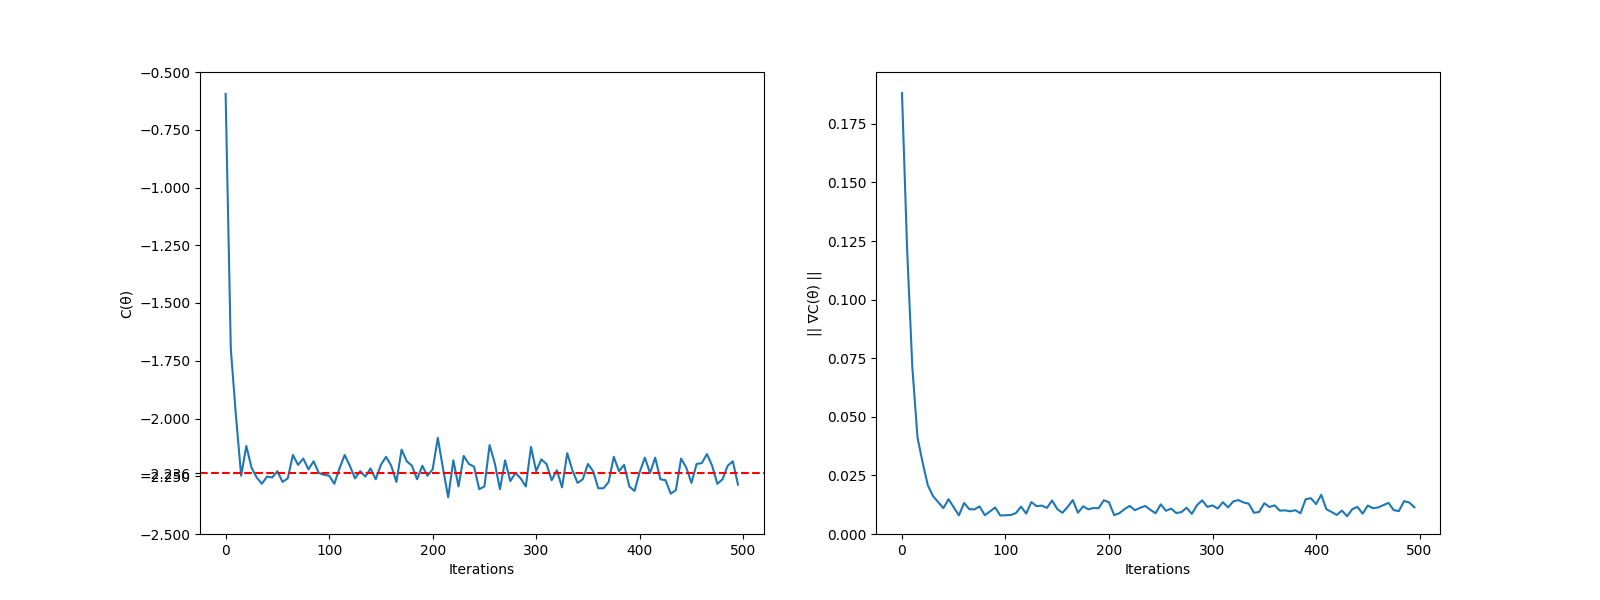

In [9]:
results = run_vqe(
    **options
)
analyze_results(results)

# takes ~2.5min on local

## Tuning of hyper parameters

Here, we define some helper subroutines to search through given space of hyperparameters as needed.

This is used to find the optimal set of values that:

1. converge the fastest
2. provide most consistent values
3. balance expressivity with computational cost

In [23]:
def get_plot():
    return plt.subplots(1, 2, figsize=(16, 6))

def linear_search_vqe(options, vars):
    all_results = []
    opts = options
    opts["plot"] = get_plot()
    
    for i in range(len(list(vars.values())[0])):
        name = ""
        for k in vars:
            val = vars[k][i]
            opts[k] = val
            name += f"{k}={val}, "

        name = name[:-2]
        
        opts["label"] = name
        
        results = run_vqe(**opts)
        analyze_results(results)
        print()
        all_results.append(results)
    
    return all_results


def grid_search_vqe(options, vars):
    all_results = []
    opts = options
    opts["plot"] = get_plot()
    
    keys = list(vars.keys())
    for vals in product(*list(vars.values())):
        name = ""
        for i, val in enumerate(vals):
            k = keys[i]
            opts[k] = val
            name += f"{k}={val}, "

        name = name[:-2]

        opts["label"] = name

        results = run_vqe(**opts)
        analyze_results(results)
        print()
        all_results.append(results)
    return all_results

### 1. Vary `steps` and `shots`, keeping total cost evaluations constant
Whether it is better to execute more shots per cost fn evaluation, as opposed to executing more iterations of the training loop, keeping total cost evaluations constant.

#### Conclusion
best balance: `steps = 500, shots = 512`

Iterations: 125
Total cost evaluations: 768000
Circuit depth: 4
δE₀ (error) = 1.1632511050418146 %
ΔE₀ (spread) = 0.07155934866497059 %
No. of iters to converge = 15
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9999827440599637

Iterations: 250
Total cost evaluations: 768000
Circuit depth: 4
δE₀ (error) = 1.8226403628997851 %
ΔE₀ (spread) = 0.10709281732587378 %
No. of iters to converge = 12
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9999804688471697

Iterations: 500
Total cost evaluations: 768000
Circuit depth: 4
δE₀ (error) = 1.7524908131670496 %
ΔE₀ (spread) = 0.17537745452419945 %
No. of iters to converge = 12
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9999285956109681

Iterations: 1000
Total cost evaluations: 768000
Circuit depth: 4
δE₀ (error) = 3.418143959365351 %
ΔE₀ (spread) = 0.4546755820279851 %
No. of iters to converge = 17
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9999411193081954



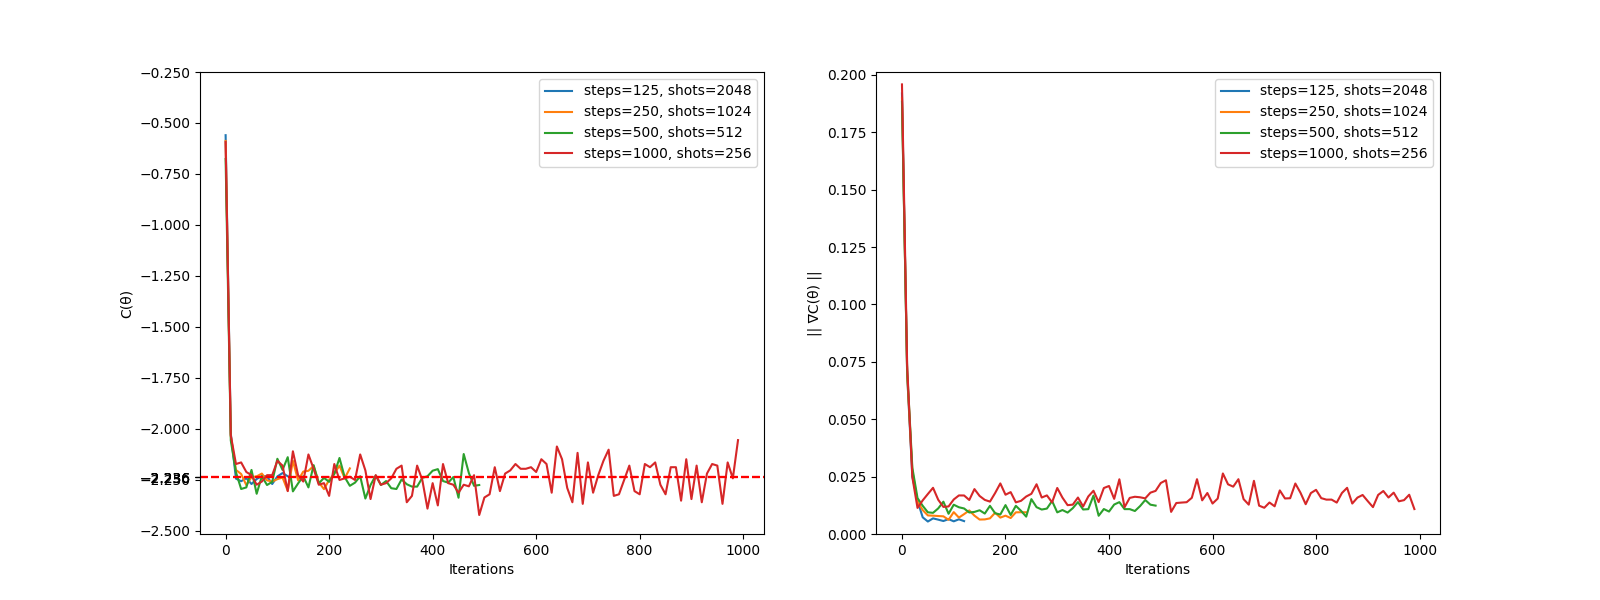

In [14]:
vars1 = {
    "steps": [125,   250,  500, 1000],
    "shots": [2048, 1024,  512,  256]
}

results1 = linear_search_vqe(options, vars1)

# takes ~12 mins on local

### 2. Vary hyperparameters for optimizer, i.e., `alpha` and `learning_rate`

#### Conclusion
`learning_rate` has a huge impact:
- Lower $\eta$ can cause *slow convergence* but we may get stuck in *suboptimal minimas*.
- Higher $\eta$ can lead to *faster convergence* but we also skip over *sharp, optimal minimas* and cause divergence, *reducing consistency*

`alpha` has lesser impact:
- Lower $\alpha$ approximates gradient more accurately but requires more evaluations and increases sensitivity to noise.
- Higher $\alpha$ traverse the parameter in lesser evaluations but can lead to less accurate gradient approximation.

Best choice: `alpha = np.pi/2, learning_rate = 0.5`.

Iterations: 1000
Total cost evaluations: 768000
Circuit depth: 4
δE₀ (error) = 6.3646534421962375 %
ΔE₀ (spread) = 1.007347478337028 %
No. of iters to converge = 85
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9999530672772969

Iterations: 1000
Total cost evaluations: 768000
Circuit depth: 4
δE₀ (error) = 3.9189540918058396 %
ΔE₀ (spread) = 0.5169344652519924 %
No. of iters to converge = 49
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9999856959515389

Iterations: 1000
Total cost evaluations: 768000
Circuit depth: 4
δE₀ (error) = 0.9724446089749537 %
ΔE₀ (spread) = 0.21791799805062068 %
No. of iters to converge = 13
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9996286489868876

Iterations: 1000
Total cost evaluations: 768000
Circuit depth: 4
δE₀ (error) = 4.81568644530272 %
ΔE₀ (spread) = 0.7561476881297244 %
No. of iters to converge = 14
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9998887046741282



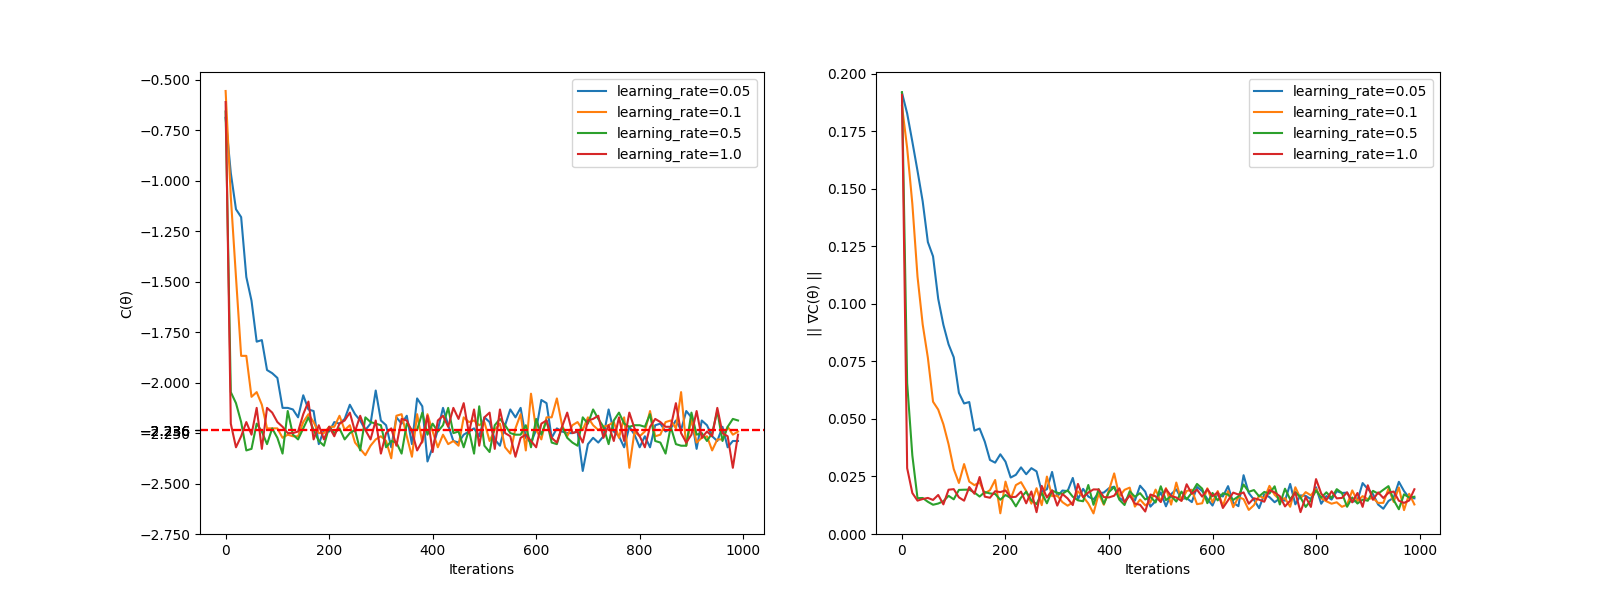

In [ ]:
vars21 = {
    "learning_rate": np.array([0.05, 0.1, 0.5, 1])
}

results21 = linear_search_vqe(options, vars21)

# takes ~16 min on local

Iterations: 500
Total cost evaluations: 768000
Circuit depth: 4
δE₀ (error) = 2.431963881569382 %
ΔE₀ (spread) = 0.24133447781951636 %
No. of iters to converge = 18
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9999638333626933

Iterations: 500
Total cost evaluations: 768000
Circuit depth: 4
δE₀ (error) = 1.2114979289379217 %
ΔE₀ (spread) = 0.1347819343797964 %
No. of iters to converge = 17
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9999120210288245

Iterations: 500
Total cost evaluations: 768000
Circuit depth: 4
δE₀ (error) = 0.16538425525379896 %
ΔE₀ (spread) = 0.09790156203528623 %
No. of iters to converge = 14
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9998839225396456



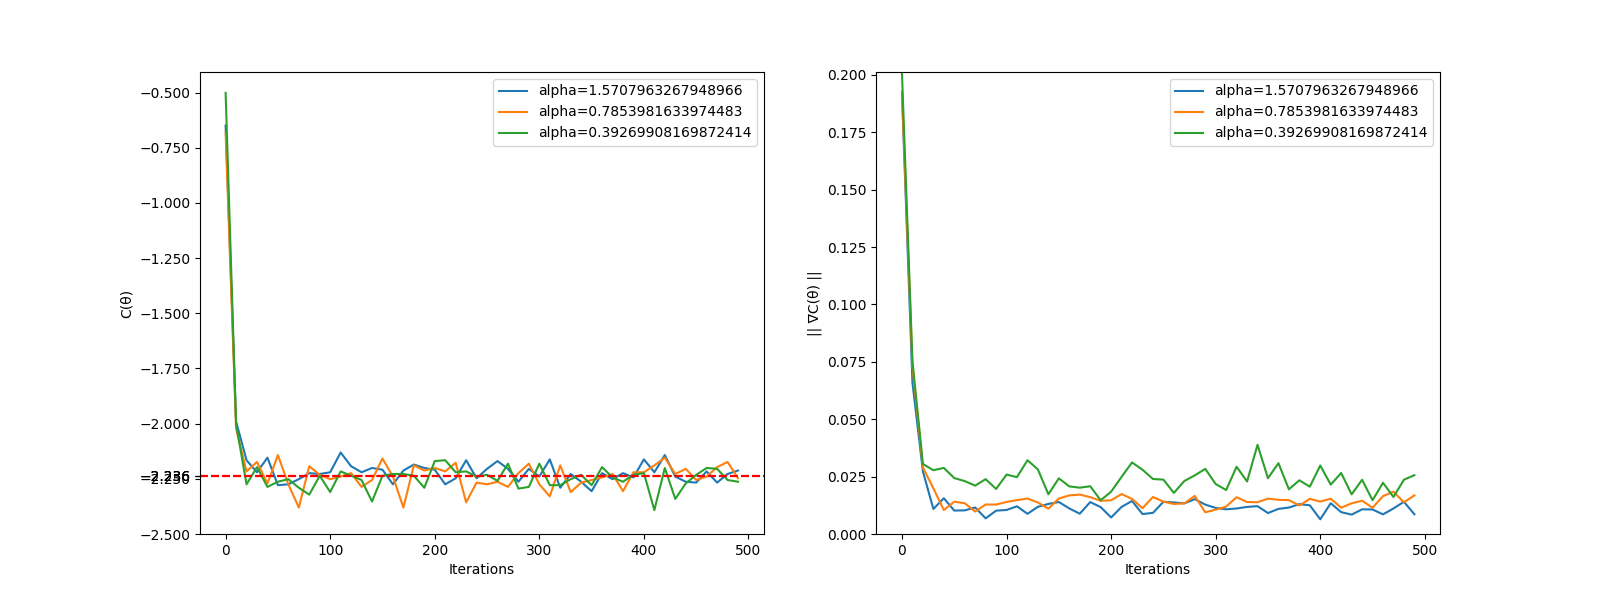

In [24]:
vars22 = {
    "alpha": np.pi / np.array([2, 4, 8])
}

results22 = linear_search_vqe(options, vars22)

# takes ~5 min on local

### 3. Vary hyperparameters for circuit, i.e., `n_qubits`, `n_layers` and `linear`

Analyze the effect of adding more complexity into the circuit and whether that can allow reaching the desired answer in lesser evaluations.

#### Conclusion
Adding more layers adds overhead and more parameters to optimize for, which *can reduce rate of convergence* but also offers increase in expressibility

Using circular entanglement with even 2 qubits (`linear=False`) offers slightly *higher rate of convergence*.

Adding another qubit and updating $H' = I \otimes H$ does not offer significant help with lesser iterations, since more parameters require more iterations to optimize. Instead, it creates a new problem that the system reaches eigenvalue `-1.0` much faster, but then convergence to true minimum slows down. †

Best option: `steps=1000, shots=256, linear=False, n_layers=4, n_qubits=2` (steps and shots can be increased at the expense of higher execution time)

---

† : This can be improved by adding an **orthogonal penalty term** ($c\ket{\psi'}\bra{\psi'}$, where $c >> 0$, $\ket{\psi'}$ is the sub-optimal, or, minimum-energy excited state) to the hamiltonian. Additionally, using higher value of learning rate $\eta$ can help.

Iterations: 500
Total cost evaluations: 768000
Circuit depth: 2
δE₀ (error) = 2.955020718411453 %
ΔE₀ (spread) = 0.32574633235834327 %
No. of iters to converge = 24
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9999233518510505

Iterations: 500
Total cost evaluations: 768000
Circuit depth: 3
δE₀ (error) = 2.2576116026220445 %
ΔE₀ (spread) = 0.2323684679894751 %
No. of iters to converge = 30
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9997455170612483

Iterations: 500
Total cost evaluations: 768000
Circuit depth: 4
δE₀ (error) = 3.1293729973588107 %
ΔE₀ (spread) = 0.3309343172668222 %
No. of iters to converge = 17
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9995754675397716



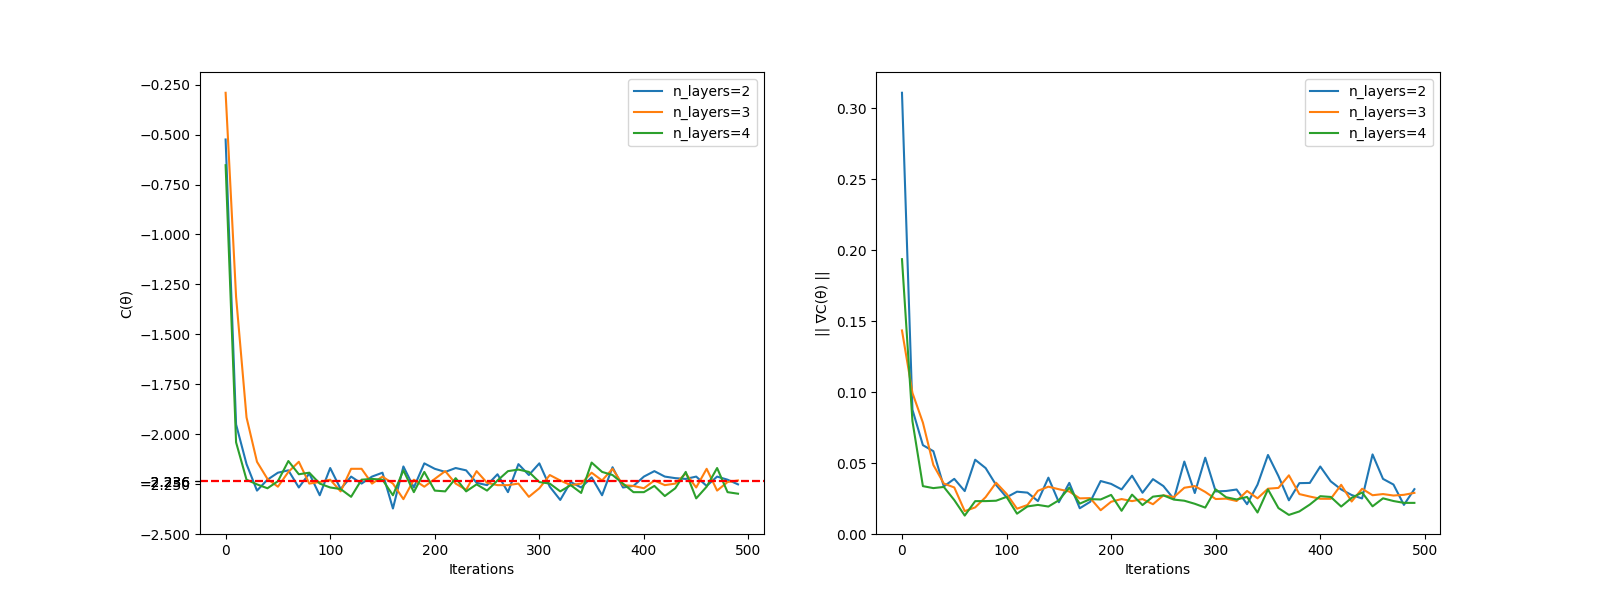

In [25]:
vars31 = {
    "n_layers": [2, 3, 4]
}

results31 = linear_search_vqe(options, vars31)

# takes ~20 min on local

Iterations: 500
Total cost evaluations: 768000
Circuit depth: 4
δE₀ (error) = 1.9089070447273304 %
ΔE₀ (spread) = 0.18150498727009054 %
No. of iters to converge = 17
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9995260350563202

Iterations: 500
Total cost evaluations: 768000
Circuit depth: 4
δE₀ (error) = 3.4780775552535044 %
ΔE₀ (spread) = 0.4859296575979851 %
No. of iters to converge = 175
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9622334355970228



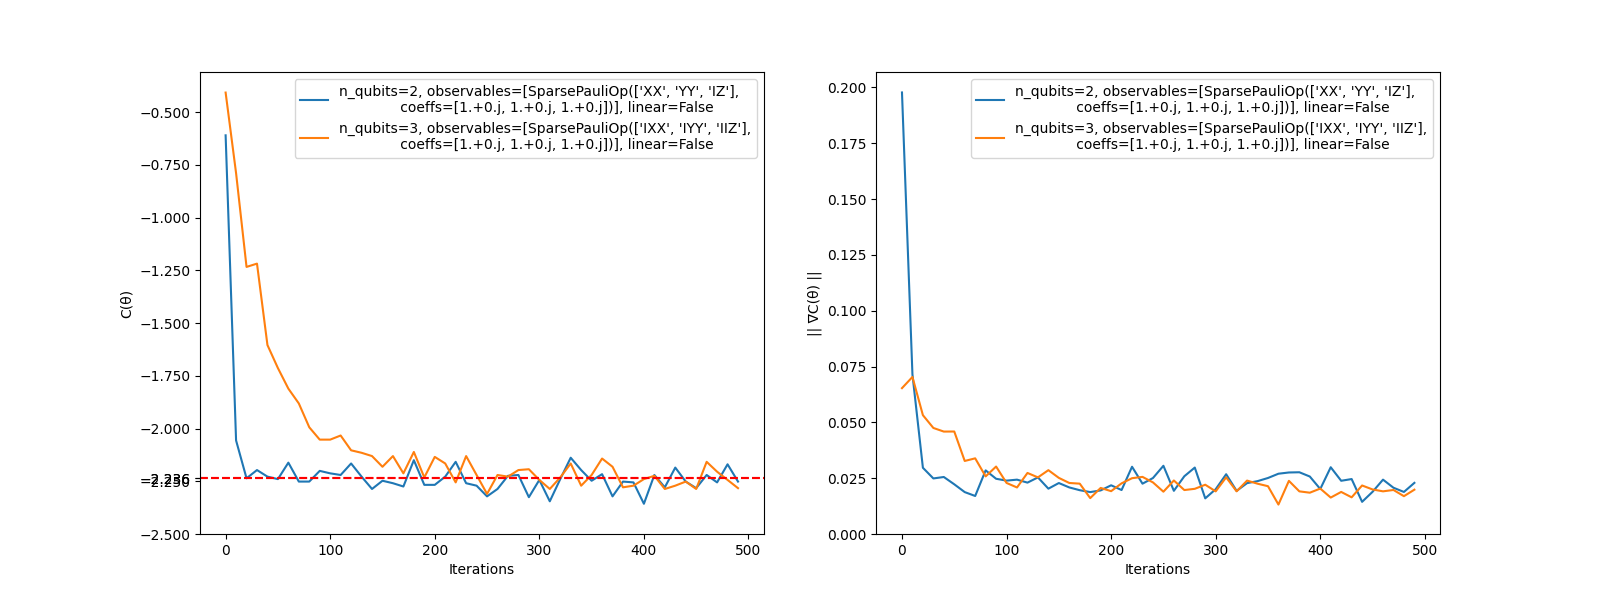

In [27]:
vars32 = {
    "n_qubits": [2, 3],
    "observables": [
        [H],
        # add I for q2
        [SparsePauliOp(["IXX", "IYY", "IIZ"])]
    ],
    "linear": [False, False]
}

results32 = linear_search_vqe(options, vars32)

# takes ~13 min on local

Iterations: 500
Total cost evaluations: 768000
Circuit depth: 4
δE₀ (error) = 0.33973653420115607 %
ΔE₀ (spread) = 0.17117741455155291 %
No. of iters to converge = 131
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9711521451912071

Iterations: 500
Total cost evaluations: 768000
Circuit depth: 4
δE₀ (error) = 3.1293729973587903 %
ΔE₀ (spread) = 0.4839797203654266 %
No. of iters to converge = 147
Fidelity: |⟨ψ_G|ψ_VQE⟩|² = 0.9749338446678731



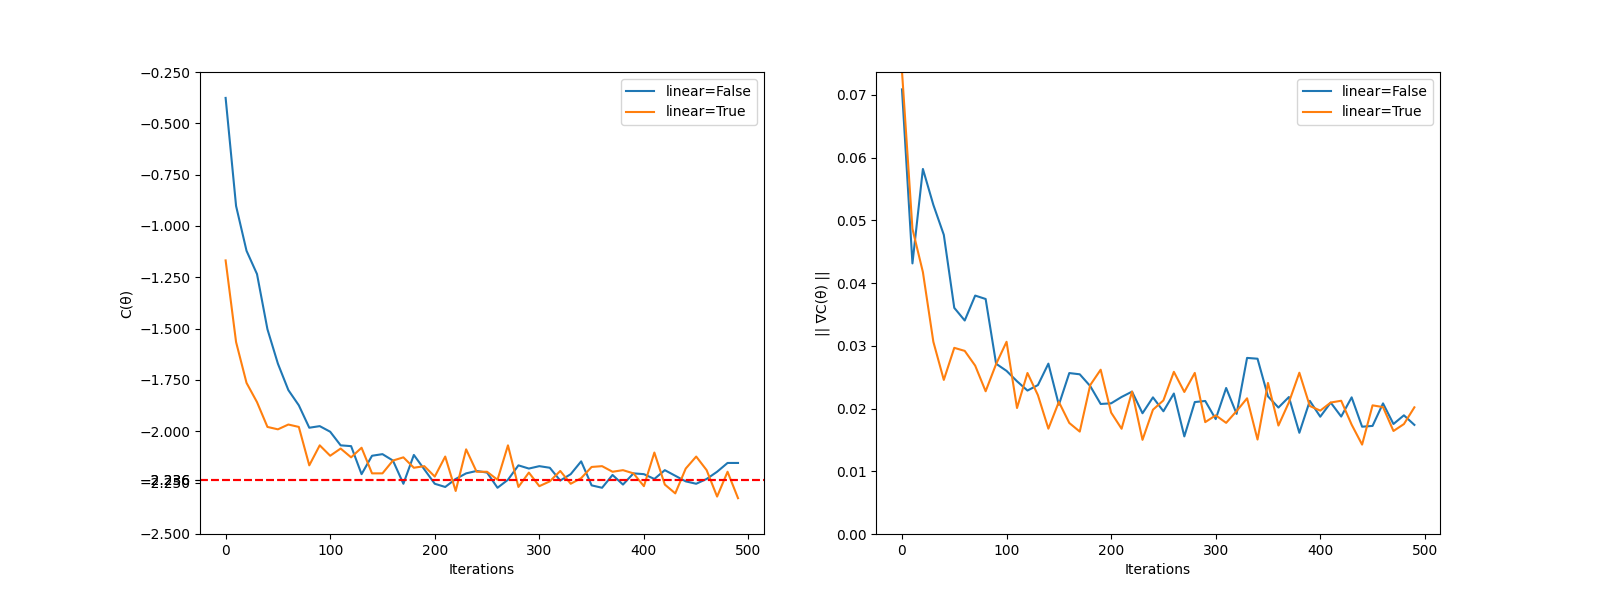

In [28]:
vars33 = {
    "linear": [False, True]
}

results33 = linear_search_vqe(options, vars33)

# takes ~4 min on local